In [1]:
%matplotlib inline

In [261]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# helper fcn for labelling axes with nonconsecutive values:
def get_inflection_points(series):
    trend_sign = np.sign(series.iloc[1] - series.iloc[0])
    yvals_iterator = series.items()
    last_yind, last_yval = next(yvals_iterator)  # pop off and add first (ind, val) pair
    inflection_point_indices = [last_yind]
    inflection_point_values = [last_yval]
    for y_ind, y_val in yvals_iterator:
        if np.sign(y_val - last_yval) == -1 * trend_sign:
            trend_sign = -1 * trend_sign
            inflection_point_indices.append(last_yind)
            inflection_point_values.append(last_yval)
        last_yind, last_yval = y_ind, y_val
    inflection_point_indices.append(y_ind)  # add last (ind, val) pair, too
    inflection_point_values.append(y_val)
    return inflection_point_indices, inflection_point_values

# plot TRKR vs B-field in 2D
def get_dataframe_XYZ_matrices(df, data_column,
                               x_values_column=None,
                               y_values_column=None):
    """
    Returns plot-ready X, Y, Z matrices from pivoting a dataframe
    along columns "X" and "Y". Expects a 2+ level multi-index and/or
    for x_values_column and y_values_column parameters to be given.
    If dataframe is 2+ level indexed _and_ one or both columns given,
    the indices will be used to determine row/col of data in table,
    but the values in X/Y matrix will utilize the [x/y]_values_column.
    Otherwise, X/Y values will be sorted numerically, although extra
    indices above two will be stacked along y-axis.
    """
    # flatten as pivot_table() handles errors much better than unstack()
    if df.index.nlevels == 1:
        if (x_values_column is None) or (y_values_column is None):
            raise ValueError("plot_dataframe_2d requires either a 2+ level " +
                             "multi-indexed dataframe or both x_- and y_- " +
                             "values_column parameters to be given.")
        excess_index_columns = []
        x_index_column = x_values_column + '_copy'
        y_index_column = y_values_column + '_copy'
        flatdf = df.reset_index()  # just in case index important
        flatdf[x_index_column] = flatdf[x_values_column]
        flatdf[y_index_column] = flatdf[y_values_column]
    else:
        excess_index_columns = list(df.index.names[:-2])
        y_index_column = df.index.names[-2]
        x_index_column = df.index.names[-1]
        flatdf = df.reset_index()
        if x_values_column is None:
            x_values_column = x_index_column + '_copy'
            flatdf[x_values_column] = flatdf[x_index_column]
        if y_values_column is None:
            y_values_column = y_index_column + '_copy'
            flatdf[y_values_column] = flatdf[y_index_column]
    # add back any extra columns above 2d to keep y-axis ordering.
    pivot_index_columns = excess_index_columns + [y_index_column]
    # just quick-check to make sure these calls don't fail:
    flatdf[data_column]
    flatdf[x_values_column]
    flatdf[y_values_column]
    flatdf[pivot_index_columns]
    flatdf[x_index_column]
    pivot_df = flatdf.pivot_table(values=[data_column, x_values_column, y_values_column],
                                  index=pivot_index_columns,
                                  columns=[x_index_column],
                                  aggfunc=lambda x: x.head(1),
                                  fill_value=0)
    xvals_df = pivot_df[x_values_column]  # pd.DataFrames in meshgrid()-style 
    yvals_df = pivot_df[y_values_column]
    zvals_df = pivot_df[data_column]
#     xvals_s = xvals_df.iloc[0]  # pd.Series w/matching x-dimensional indexing
#     yvals_s = yvals_df.T.iloc[0]
    X = xvals_df.values
    Y = yvals_df.values
    Z = zvals_df.values
    return X, Y, Z

def plot_dataframe_2d(df, data_column,
                      x_values_column=None, y_values_column=None,
                      ax=None):
    X, Y, Z = get_dataframe_XYZ_matrices(df, data_column,
                                         x_values_column, y_values_column)
    xvals = X[0, :]
    yvals = Y[:, 0]
    if ax is None:
        plt.figure(figsize=(6,6))
        ax = plt.subplot(111)
    ax.imshow(zvals_df, cmap='jet', interpolation='nearest', aspect=0.8 * len(xvals) / len(yvals))

#     plot_label_column_names = ['wavelength', 'pump_power']
#     plotlabel = "\n".join(['{}: {}'.format(colname, dataframe.loc[run_id][colname].iloc[0])
#                            for colname in plot_label_column_names])
#     ax.text(1.1, 0.9, plotlabel, verticalalignment='top', horizontalalignment='left',
#             transform=ax.transAxes, color='black', fontsize=16)

    def get_axis_ticks(axis_data_series, use_inflection_points=False):
        if use_inflection_points:
            return get_inflection_points(axis_data_series)
        else:
            if len(axis_data_series) < 6:
                return xvals_s.index, xvals_s.values
            else:
                 return None, []
    x_tick_label_indices, x_tick_label_values = get_axis_ticks(xvals_s,
                                                               use_inflection_points=False)
    x_tick_labels = ["{:.1f} ns".format(val / 1000)
                     for val in x_tick_label_values]
    y_tick_label_indices, y_tick_label_values = get_axis_ticks(yvals_s,
                                                               use_inflection_points=True)
    y_tick_labels = ["{:d} mT".format(int(val * 1000))
                     for val in y_tick_label_values]
    if x_tick_label_indices is not None:
        plt.xticks(x_tick_label_indices, x_tick_labels)
    if x_tick_label_indices is not None:
        plt.yticks(y_tick_label_indices, y_tick_labels)

    plt.show()
        
def plot_2d_with_run_id_slider(dataframe, data_column,
                               x_values_column=None, y_values_column=None):
    """
    Expects a 3-level-multi-indexed dataframe and a column name corresponding
    to the value to be plotted. Optionally, columns containing values corresponding
    to each axis can be provided, otherwise the labels in the dataframe's index
    will be used.
    """
    def plot_2d_by_3rd_index(dataframe, third_index):
        plot_dataframe_2d(dataframe.xs(third_index, level=-3), 
                          data_column, x_values_column, y_values_column)

    run_id_slider = widgets.IntSlider(min=0, max=dataframe.index.get_level_values('run_id').max(),
                                      value=0, description='Run ID:')
    widgets.interact(plot_2d_by_3rd_index, dataframe=widgets.fixed(dataframe), run_id=run_id_slider);


# Simulation Data

In [262]:
# import jtplot submodule from jupyterthemes IF installed
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=1.6)
    # set the default figure size
    jtplot.figsize(x=4., y=4.)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


b_external  kerr_rotation  probe_delay
run_id index_2d index_1d                                        
1      1060     11             200.0      -0.000010       -172.0
                12             200.0      -0.000020       -144.0
                13             200.0       0.000004       -116.0
                14             200.0       0.000018        -88.0
                15             200.0      -0.000025        -60.0

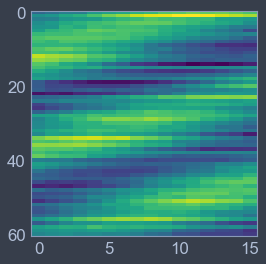

In [265]:
import experimentdataanalysis.simulations.simple_trkr_rsa_simulation as simple_trkr_rsa_simulation

# independent params
seed = 10

ndatasets = 61
nx = 16
dataset_bvals = np.linspace(200, 230, ndatasets)
tvals = np.linspace(-480, -60, nx)

# TEMP - full TRKR scans over huge B-range
# ndatasets = 51
# nx = 251
# dataset_bvals = np.linspace(0, 200, ndatasets)
# tvals = np.linspace(-500, 7000, nx)

# simulation constants & randomly generated params
simulation_constants = {
    'pulse_amplitude_mean': 1e-3,
    'pulse_amplitude_std_err': 2e-5,
    'gfactor': 0.439,
    'spin_lifetime_mean': 10000,
    'spin_lifetime_std_err': 2000,
    'initial_phase': 0.0 * np.pi,
    'extra_phase_offset_baseline': 0.0 * np.pi,
    'extra_phase_offset_cos_amp': 0.1 * np.pi,
    'extra_phase_offset_cos_nperiods': 3.0,
    'slopes_scale': 0.0,
    'offsets_scale': 1e-4,
    'noise_scale': 2e-5,
}

simulation_params_1 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_params(nx, ndatasets,
                                                               simulation_constants, seed)
dataframe_1 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_dataframe(tvals, dataset_bvals,
                                                                  simulation_params,
                                                                  suppress_plot=False)
simulation_params_2 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_params(nx, ndatasets,
                                                               simulation_constants, seed + 1)
dataframe_2 = \
    simple_trkr_rsa_simulation.generate_TRKR_simulation_dataframe(tvals, dataset_bvals[::-1],
                                                                  simulation_params,
                                                                  suppress_plot=True)
dataframe_2.index.map(lambda x: (x[0] + 1, x[1], x[2]))
dataframe_2.index = dataframe_2.index.map(lambda x: (x[0] + 1, x[1] - 1000, x[2]))
dataframe_2.index.set_names(dataframe_1.index.names)
dataframe = pd.concat([dataframe_1, dataframe_2])
dataframe.tail(5)

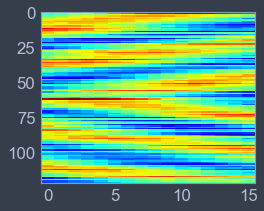

In [266]:
# TEST WITH >2D INDICES
plt.figure()
ax = plt.subplot(111)
data_column = 'kerr_rotation'
x_values_column = 'probe_delay'
y_values_column = 'b_external'
plot_dataframe_2d(dataframe,
                  data_column,
                  x_values_column=x_values_column,
                  y_values_column=y_values_column,
                  ax=ax)
